In [1]:
import psycopg2
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
# Connecting to the Database
print("Trying to connect to db")
conn = psycopg2.connect(
    database="piscineds",
    user="ggobert",
    password="mysecretpassword",
    host=0
)
print("Connection success!")

cur = conn.cursor()

cur.execute("""
    WITH purchases AS (
        SELECT 
            user_id,
            event_time,
            CAST(REPLACE(REPLACE(price::text, '$', ''), ',', '') AS FLOAT) AS price
        FROM 
            customers
        WHERE 
            event_type = 'purchase'
    ),

    last_date AS (
        SELECT 
            MAX(event_time) AS max_date
        FROM 
            purchases
    ),

    rfm_base AS (
        SELECT 
            p.user_id,
            MAX(p.event_time) AS last_purchase,
            COUNT(*) AS frequency,
            SUM(p.price) AS monetary
        FROM 
            purchases p
        GROUP BY 
            p.user_id
    )

    SELECT 
        EXTRACT(DAY FROM (l.max_date - r.last_purchase)) AS recency,
        r.frequency,
        r.monetary
    FROM 
        rfm_base r, last_date l;
""")

results = cur.fetchall()

cur.close()
conn.close()

Trying to connect to db
Connection success!


In [3]:
dataset = pd.DataFrame(results, columns=["recency", "frequency", "monetary"])
dataset = dataset.astype(float)

In [4]:
# Standardiser
scaler = StandardScaler()
scaled_rfm = scaler.fit_transform(dataset)

In [5]:
from sklearn.cluster import KMeans

inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_rfm)
    inertia.append(kmeans.inertia_)

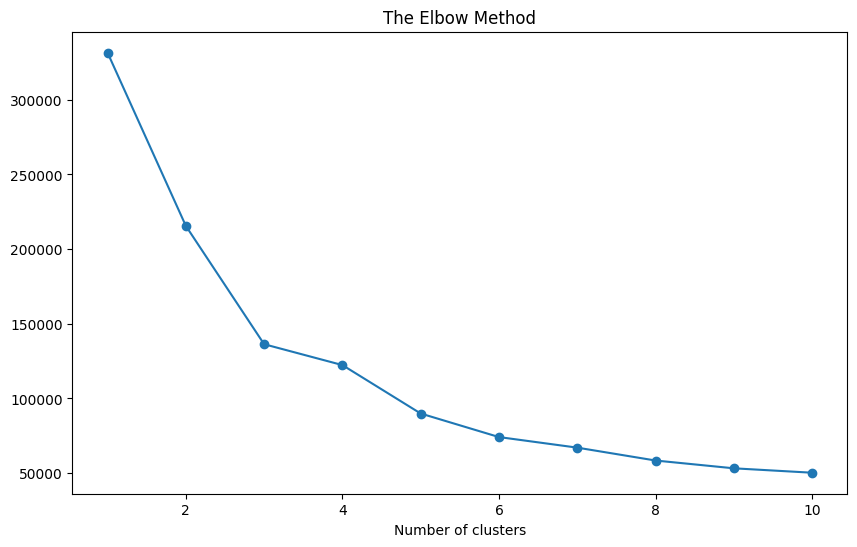

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.show()